# Pylint and Radon on all Code Blocks

In [19]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
query = """
SELECT
    c.*,
    m.conversation_id, m.message_id,
    u.user_id, u.gender, u.work_exp_years, u.age
FROM code_blocks c
JOIN messages m ON c.message_id = m.message_id
JOIN conversations conv ON m.conversation_id = conv.conversation_id
JOIN users u ON conv.user_id = u.user_id
"""

code_blocks = pd.read_sql(query, conn)

code_blocks = code_blocks.dropna(subset=['code_text'])
code_blocks = code_blocks[code_blocks['code_text'].str.strip() != '']
code_blocks = code_blocks.dropna(subset=['code_text'])
code_blocks = code_blocks[(code_blocks['gender'] == 'Woman (cisgender)') | (code_blocks['gender'] == 'Man (cisgender)')]
code_blocks = code_blocks[(code_blocks['language'] == 'python')]

code_blocks

,code_block_id,message_id,code_text,language,conversation_id,message_id,user_id,gender,work_exp_years,age
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,2,6,Man (cisgender),3.0,19-25
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,2,6,Man (cisgender),3.0,19-25
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,2,6,Man (cisgender),3.0,19-25
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,6,16,Woman (cisgender),None,19-25
5,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,8,16,Woman (cisgender),None,19-25
...,...,...,...,...,...,...,...,...,...,...
1738,1739,1844,\n import cv2\nimport numpy as np\nimp...,python,2,1844,8,Man (cisgender),1.0,19-25
1739,1740,1846,\n # Figur erstellen\n p...,python,37,1846,29,Woman (cisgender),None,26-30
1740,1741,1848,\n # Plotte Daten für beide...,python,37,1848,29,Woman (cisgender),None,26-30
1741,1742,1852,\n # Step 1: Load and Visua...,python,2,1852,8,Man (cisgender),1.0,19-25


## Subsample from user 73

In [20]:
def subsample_code_blocks(df, user_id, n=50):
    """Subsample up to n code blocks from the specified user, keep all others."""
    # Separate the code blocks for the target user
    user_blocks = df[df['user_id'] == user_id]
    other_blocks = df[df['user_id'] != user_id]

    # Subsample n code blocks for the target user (if < n rows, use all)
    sample_n = min(n, len(user_blocks))
    user_blocks_sampled = user_blocks.sample(n=sample_n, random_state=42)

    # Combine with the original code blocks from other users
    combined = pd.concat([other_blocks, user_blocks_sampled], ignore_index=True)

    # Summarize number of code blocks per user
    summary_per_user = combined.groupby('user_id')['code_text'].nunique().reset_index(name='num_code_blocks')
    user_gender = combined[['user_id', 'gender']].drop_duplicates()
    summary_with_gender = summary_per_user.merge(user_gender, on='user_id', how='left')
    print(summary_with_gender.groupby('gender').sum(numeric_only=True))

    # Number of users per gender in the new subset
    users_per_gender = combined.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
    print(users_per_gender)

    return combined

# Example usage:
code_blocks = subsample_code_blocks(code_blocks, user_id=73, n=50)
code_blocks


                   user_id  num_code_blocks
gender                                     
Man (cisgender)        610              152
Woman (cisgender)      706              354
              gender  num_users
0    Man (cisgender)         11
1  Woman (cisgender)         13


,code_block_id,message_id,code_text,language,conversation_id,message_id,user_id,gender,work_exp_years,age
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,2,6,Man (cisgender),3.0,19-25
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,2,6,Man (cisgender),3.0,19-25
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,2,6,Man (cisgender),3.0,19-25
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,6,16,Woman (cisgender),None,19-25
4,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,8,16,Woman (cisgender),None,19-25
...,...,...,...,...,...,...,...,...,...,...
524,554,545,import pandas as pd\n\n# Load your dataset\nda...,python,21,545,73,Woman (cisgender),None,31-35
525,279,367,from sklearn.svm import OneClassSVM\n\n# Train...,python,21,367,73,Woman (cisgender),None,31-35
526,353,411,from autogluon.vision import ImagePredictor\n\...,python,21,411,73,Woman (cisgender),None,31-35
527,1332,1379,"new_param_grid = {\n 'min_samples': [15, 20...",python,65,1379,73,Woman (cisgender),None,31-35


In [2]:
from helpers.pylint_radon import calc_radon_metrics, run_pylint_on_code

print("Running radon analysis on all code blocks...")
metrics = code_blocks['code_text'].apply(calc_radon_metrics)
columns = ['radon_complexity', 'radon_maintainability_index',
           'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments']
for idx, col in enumerate(columns):
    code_blocks[col] = metrics.apply(lambda vals: vals[idx])


print("Running pylint on all code blocks...")
code_blocks['pylint_score'], code_blocks['pylint_messages'], code_blocks['pylint_codes'] = zip(*code_blocks.apply(lambda row: run_pylint_on_code(row['code_text']), axis=1))

code_blocks

Running radon analysis on all code blocks...
Running pylint on all code blocks...


,code_block_id,message_id,code_text,language,conversation_id,message_id,user_id,gender,work_exp_years,age,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,radon_lloc,radon_comments,pylint_score,pylint_messages,pylint_codes
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,2,6,Man (cisgender),3.0,19-25,0.0,100.000000,2.0,2.0,2.0,0.0,10.00,------------------------------------\nYour cod...,[]
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,2,6,Man (cisgender),3.0,19-25,0.0,100.000000,3.0,3.0,3.0,0.0,10.00,------------------------------------\nYour cod...,[]
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,2,6,Man (cisgender),3.0,19-25,0.0,100.000000,5.0,4.0,4.0,0.0,10.00,------------------------------------\nYour cod...,[]
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,6,16,Woman (cisgender),None,19-25,0.0,100.000000,21.0,9.0,10.0,6.0,10.00,------------------------------------\nYour cod...,[]
5,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,8,16,Woman (cisgender),None,19-25,0.0,100.000000,11.0,5.0,7.0,3.0,10.00,------------------------------------\nYour cod...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,1739,1844,\n import cv2\nimport numpy as np\nimp...,python,2,1844,8,Man (cisgender),1.0,19-25,NaN,NaN,101.0,59.0,57.0,25.0,NaN,************* Module tmpu59l985l\n/var/folders...,[E0001]
1739,1740,1846,\n # Figur erstellen\n p...,python,37,1846,29,Woman (cisgender),None,26-30,NaN,NaN,51.0,30.0,21.0,11.0,NaN,************* Module tmpdwu7iflb\n/var/folders...,[E0001]
1740,1741,1848,\n # Plotte Daten für beide...,python,37,1848,29,Woman (cisgender),None,26-30,NaN,NaN,40.0,26.0,19.0,8.0,NaN,************* Module tmpvfojq834\n/var/folders...,[E0001]
1741,1742,1852,\n # Step 1: Load and Visua...,python,2,1852,8,Man (cisgender),1.0,19-25,0.0,81.306505,51.0,33.0,31.0,7.0,8.28,************* Module tmp0q11chyt\n/var/folders...,"[C0103, C0103, R1720, R1720, C0411]"


In [6]:
code_blocks = code_blocks.drop_duplicates(subset=['code_text'])
code_blocks = code_blocks.loc[:, ~code_blocks.columns.duplicated()]
code_blocks

,code_block_id,message_id,code_text,language,conversation_id,user_id,gender,work_exp_years,age,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,radon_lloc,radon_comments,pylint_score,pylint_messages,pylint_codes
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,6,Man (cisgender),3.0,19-25,0.0,100.000000,2.0,2.0,2.0,0.0,10.00,------------------------------------\nYour cod...,[]
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,6,Man (cisgender),3.0,19-25,0.0,100.000000,3.0,3.0,3.0,0.0,10.00,------------------------------------\nYour cod...,[]
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,6,Man (cisgender),3.0,19-25,0.0,100.000000,5.0,4.0,4.0,0.0,10.00,------------------------------------\nYour cod...,[]
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,16,Woman (cisgender),None,19-25,0.0,100.000000,21.0,9.0,10.0,6.0,10.00,------------------------------------\nYour cod...,[]
5,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,16,Woman (cisgender),None,19-25,0.0,100.000000,11.0,5.0,7.0,3.0,10.00,------------------------------------\nYour cod...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,1694,1750,\n # Plotte Daten für beide...,python,29,90,Woman (cisgender),2.0,26-30,NaN,NaN,40.0,26.0,19.0,8.0,NaN,************* Module tmpys_kby1e\n/var/folders...,[E0001]
1694,1695,1752,\n import cv2\n import i...,python,19,63,Woman (cisgender),2.0,26-30,NaN,NaN,61.0,39.0,29.0,6.0,NaN,************* Module tmpdvtxi6qd\n/var/folders...,[E0001]
1695,1696,1754,\n import cv2\n\n def ex...,python,19,63,Woman (cisgender),2.0,26-30,NaN,NaN,66.0,45.0,34.0,6.0,NaN,************* Module tmpmxpaa7a5\n/var/folders...,[E0001]
1737,1738,1844,\n # Step 1: Load and Visua...,python,2,8,Man (cisgender),1.0,19-25,0.0,81.306505,51.0,33.0,31.0,7.0,8.28,************* Module tmphgx1xdkm\n/var/folders...,"[C0103, C0103, R1720, R1720, C0411]"


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

#one hot encoding for pylint scores
mlb = MultiLabelBinarizer()
binarized = pd.DataFrame(mlb.fit_transform(code_blocks['pylint_codes']),
                       columns=mlb.classes_,
                       index=code_blocks.index)
concatenated = pd.concat([code_blocks, binarized], axis=1)
cleaned = concatenated.drop(columns=['pylint_codes'])

code_blocks = cleaned

code_blocks.to_sql("all_code_block_with_scores", conn, if_exists="replace", index=False)

985

## Analyze Scores


### Cleaning out short files


In [8]:
code_blocks = code_blocks[code_blocks['radon_sloc'] >= 10]

In [9]:
users_per_gender = code_blocks.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),9
1,Woman (cisgender),12


In [11]:
code_blocks_per_user = code_blocks.groupby(['user_id', 'gender'])['code_text'].nunique().reset_index(name='num_blocks')
code_blocks_per_user

,user_id,gender,num_prompts
0,6,Man (cisgender),2
1,8,Man (cisgender),2
2,11,Woman (cisgender),8
3,16,Woman (cisgender),10
4,28,Woman (cisgender),9
5,34,Man (cisgender),56
6,46,Man (cisgender),8
7,48,Woman (cisgender),3
8,55,Woman (cisgender),34
9,56,Man (cisgender),5


## T-test

In [16]:
from statsmodels.stats.multitest import multipletests
from helpers.statistical_tests import compare_genders

print("Average pylint score (Female):", code_blocks[code_blocks['gender'] == 'Woman (cisgender)']['pylint_score'].mean())
print("Average pylint score (Male):", code_blocks[code_blocks['gender'] == 'Man (cisgender)']['pylint_score'].mean())


def groupwise_comparison_with_correction(df, columns):
    p_vals = []
    test_types = []
    female_vars = []
    male_vars = []
    nonzero_females = []
    nonzero_males = []
    for col in columns:
        p_value, test_type, female_var, male_var, nonzero_female, nonzero_male = compare_genders(df, col)
        p_vals.append(p_value)
        test_types.append(test_type)
        female_vars.append(female_var)
        male_vars.append(male_var)
        nonzero_females.append(nonzero_female)
        nonzero_males.append(nonzero_male)
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'metric': columns,
        'test type': test_types,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'f_var': female_vars,
        'm_var': male_vars,
        'n_hits': [{'female': f, 'male': m} for f, m in zip(nonzero_females, nonzero_males)]
    })
    return results



results = groupwise_comparison_with_correction(code_blocks, ['pylint_score', 'radon_complexity', 'radon_maintainability_index', 'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments'])
results



Average pylint score (Female): 8.181245901639343
Average pylint score (Male): 7.812584269662921


,metric,test type,p_value,corrected p_value,f_var,m_var,n_hits
0,pylint_score,U-test,5.466386e-02,0.054664,2.920119,3.058135,"{'female': 301, 'male': 89}"
1,radon_complexity,U-test,1.411973e-02,0.016473,10.658284,3.482632,"{'female': 166, 'male': 74}"
2,radon_maintainability_index,U-test,2.519190e-06,0.000006,205.233379,173.001829,"{'female': 305, 'male': 89}"
3,radon_loc,U-test,1.213938e-05,0.000021,2072.837631,2384.307700,"{'female': 311, 'male': 98}"
4,radon_sloc,U-test,7.747011e-04,0.001085,1116.593030,818.823901,"{'female': 311, 'male': 98}"
5,radon_lloc,U-test,1.466397e-06,0.000005,947.152349,820.823164,"{'female': 311, 'male': 98}"
6,radon_comments,U-test,5.045383e-07,0.000004,28.624085,153.905323,"{'female': 287, 'male': 95}"


## Plot

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_21999/3178528713.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


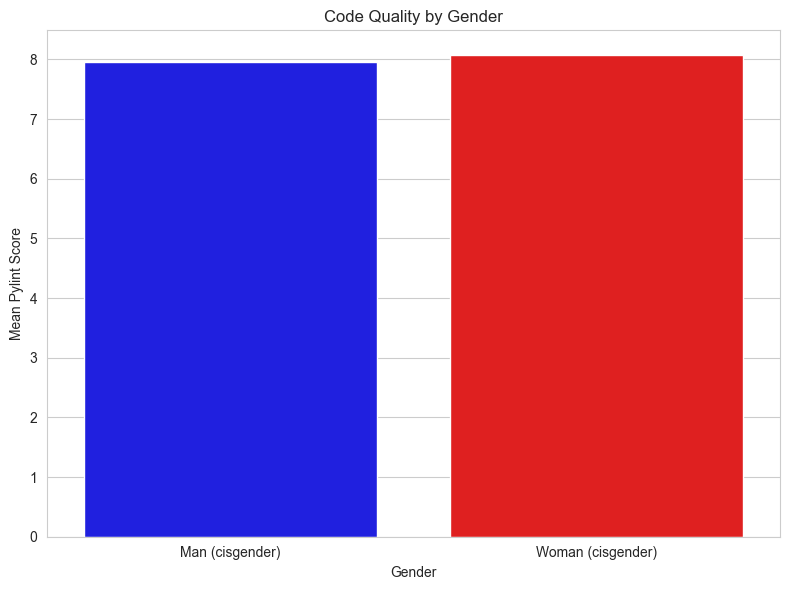

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_21999/3178528713.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


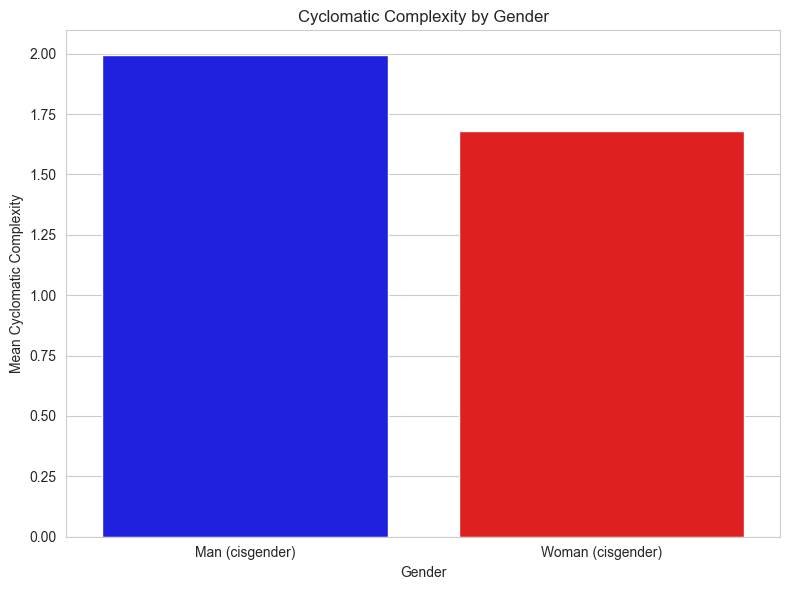

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_21999/3178528713.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


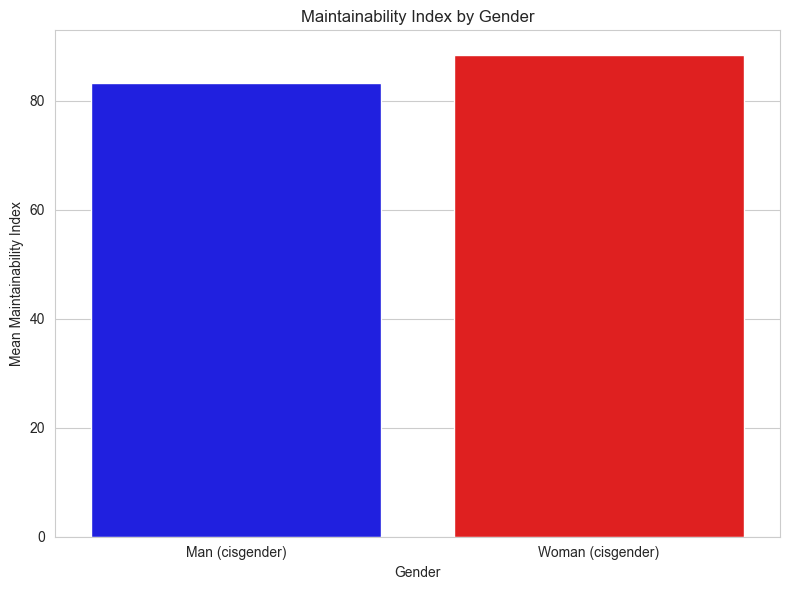

Man (cisgender): 98
Woman (cisgender): 311


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 1. Pylint Score ----

user_avg = (
    code_blocks.groupby(['user_id', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

plot_df = (
    user_avg.groupby(['gender'])['pylint_score']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df,
    x='gender',
    y='pylint_score',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Pylint Score')
plt.title('Code Quality by Gender')
plt.tight_layout()
plt.show()

# ---- 2. Radon Cyclomatic Complexity ----

user_avg_complexity = (
    code_blocks.groupby(['user_id', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plot_df_complexity = (
    user_avg_complexity.groupby(['gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_complexity,
    x='gender',
    y='radon_complexity',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Cyclomatic Complexity')
plt.title('Cyclomatic Complexity by Gender')
plt.tight_layout()
plt.show()

# ---- 3. Radon Maintainability Index ----

user_avg_mi = (
    code_blocks.groupby(['user_id', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plot_df_mi = (
    user_avg_mi.groupby(['gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_mi,
    x='gender',
    y='radon_maintainability_index',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Maintainability Index')
plt.title('Maintainability Index by Gender')
plt.tight_layout()
plt.show()

# ---- Optional: Distribution summary ----
summary = code_blocks.groupby(['gender']).size()
for gender, count in summary.items():
    print(f"{gender}: {count}")